# SSDS5. Supervised ML with PySpark

## Regression & Classification

In [1]:
!wget -q https://archive.apache.org/dist/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz
!tar xf spark-3.2.4-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import findspark
findspark.init("/content/spark-3.2.4-bin-hadoop3.2")

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

## Mount

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
gpath = '/gdrive/MyDrive/data/'

## Linear regression

In [22]:
# Load training data
df = spark.read.option("header", "true") \
                    .option("inferSchema", "true") \
                    .csv(gpath+'Housing.csv')

df.show()

+---+-------+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+
|_c0|  price|lotsize|bedrooms|bathrms|stories|driveway|recroom|fullbase|gashw|airco|garagepl|prefarea|
+---+-------+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+
|  1|42000.0|   5850|       3|      1|      2|     yes|     no|     yes|   no|   no|       1|      no|
|  2|38500.0|   4000|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|
|  3|49500.0|   3060|       3|      1|      1|     yes|     no|      no|   no|   no|       0|      no|
|  4|60500.0|   6650|       3|      1|      2|     yes|    yes|      no|   no|   no|       0|      no|
|  5|61000.0|   6360|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|
|  6|66000.0|   4160|       3|      1|      1|     yes|    yes|     yes|   no|  yes|       0|      no|
|  7|66000.0|   3880|       3|      2|      2|     yes|     no|     yes| 

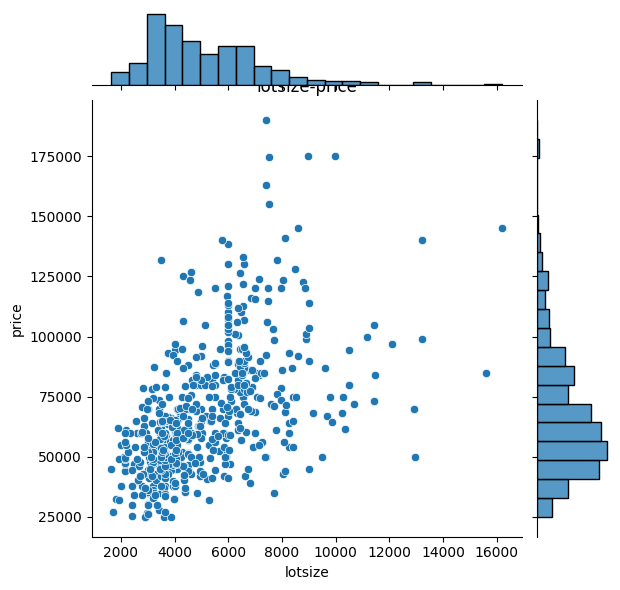

In [23]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

df_pd = df.toPandas()
# 'price' 컬럼이 object 타입으로 들어와서 numeric으로 변경
df_pd['price'] = pd.to_numeric(df_pd['price'])
sns.jointplot(x="lotsize", y="price", data=df_pd)
plt.title("lotsize-price")
plt.show()

In [24]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# use only one column 'lotsize' now
training = VectorAssembler(inputCols=["lotsize"], outputCol="features").transform(df)
training.show(5)

+---+-------+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+--------+
|_c0|  price|lotsize|bedrooms|bathrms|stories|driveway|recroom|fullbase|gashw|airco|garagepl|prefarea|features|
+---+-------+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+--------+
|  1|42000.0|   5850|       3|      1|      2|     yes|     no|     yes|   no|   no|       1|      no|[5850.0]|
|  2|38500.0|   4000|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|[4000.0]|
|  3|49500.0|   3060|       3|      1|      1|     yes|     no|      no|   no|   no|       0|      no|[3060.0]|
|  4|60500.0|   6650|       3|      1|      2|     yes|    yes|      no|   no|   no|       0|      no|[6650.0]|
|  5|61000.0|   6360|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|[6360.0]|
+---+-------+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+--

In [25]:
from pyspark.ml.regression import LinearRegression
# regParam, elasticNetParam 둘 다 설정해야 totalIterations 0이 나오지 않음
# 둘 중 하나는 0으로 설정해야 p-value 나옴, 두 변수 모두 default 0
lr = LinearRegression(featuresCol='features', labelCol="price", maxIter=100, regParam=0.5, elasticNetParam=0)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)

# Objective function (scaled loss + regularization) at each iteration.
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [6.598643918211042]
Intercept: 34136.828503689074
numIterations: 0
objectiveHistory: [0.0]


/content/spark-3.2.4-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-------------------+
|          residuals|
+-------------------+
|-30738.895425223673|
|-22031.404176533244|
| -4828.678893414864|
|-17517.810559792502|
|  -15104.2038235113|
|  4412.812796552986|
| 6260.4330936520855|
|  7412.812796552986|
|  17989.68068889792|
|  18070.62994615019|
|   8352.93528519143|
|-23432.760258322203|
| -18354.52316464785|
| -17140.92298813688|
| -20891.94660924883|
|-17253.509383191245|
|-15412.353433785509|
|-27699.776878386503|
|-11902.150021517169|
|-15439.023161678284|
+-------------------+
only showing top 20 rows

RMSE: 22525.681840
r2: 0.287077


In [26]:
#학습된 모델에 대한 정보 확인
print("coefficients: %s" % str(lrModel.coefficients))
print("intercept: %s" % str(lrModel.intercept))

coefficients: [6.598643918211042]
intercept: 34136.828503689074


In [27]:
trainingSummary = lrModel.summary

print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
print("Adj r2: %f" % trainingSummary.r2adj)

RMSE: 22525.681840
r2: 0.287077
Adj r2: 0.285766


In [28]:
import numpy as np

def modelSummary(model):
    print ("Note: the last rows are the information for Intercept")
    print ("##","-------------------------------------------------")
    print ("##","  Estimate   |   Std.Error | t Values  |  P-value")
    coef = np.append(list(model.coefficients),model.intercept)
    Summary=model.summary

    for i in range(len(Summary.pValues)):
        print ("##",'{:10.6f}'.format(coef[i]),\
        '{:10.6f}'.format(Summary.coefficientStandardErrors[i]),\
        '{:8.3f}'.format(Summary.tValues[i]),\
        '{:10.6f}'.format(Summary.pValues[i]))

    print ("##",'---')
    print ("##","Mean squared error: % .6f" \
           % Summary.meanSquaredError, ", RMSE: % .6f" \
           % Summary.rootMeanSquaredError )
    print ("##","Multiple R-squared: %f" % Summary.r2, ", \
            Total iterations: %i"% Summary.totalIterations)

In [29]:
modelSummary(lrModel)

Note: the last rows are the information for Intercept
## -------------------------------------------------
##   Estimate   |   Std.Error | t Values  |  P-value
##   6.598644   0.445842   14.800   0.000000
## 34136.828504 2491.043776   13.704   0.000000
## ---
## Mean squared error:  507406342.344941 , RMSE:  22525.681840
## Multiple R-squared: 0.287077 ,             Total iterations: 0


#### Multivariate Linear Regression

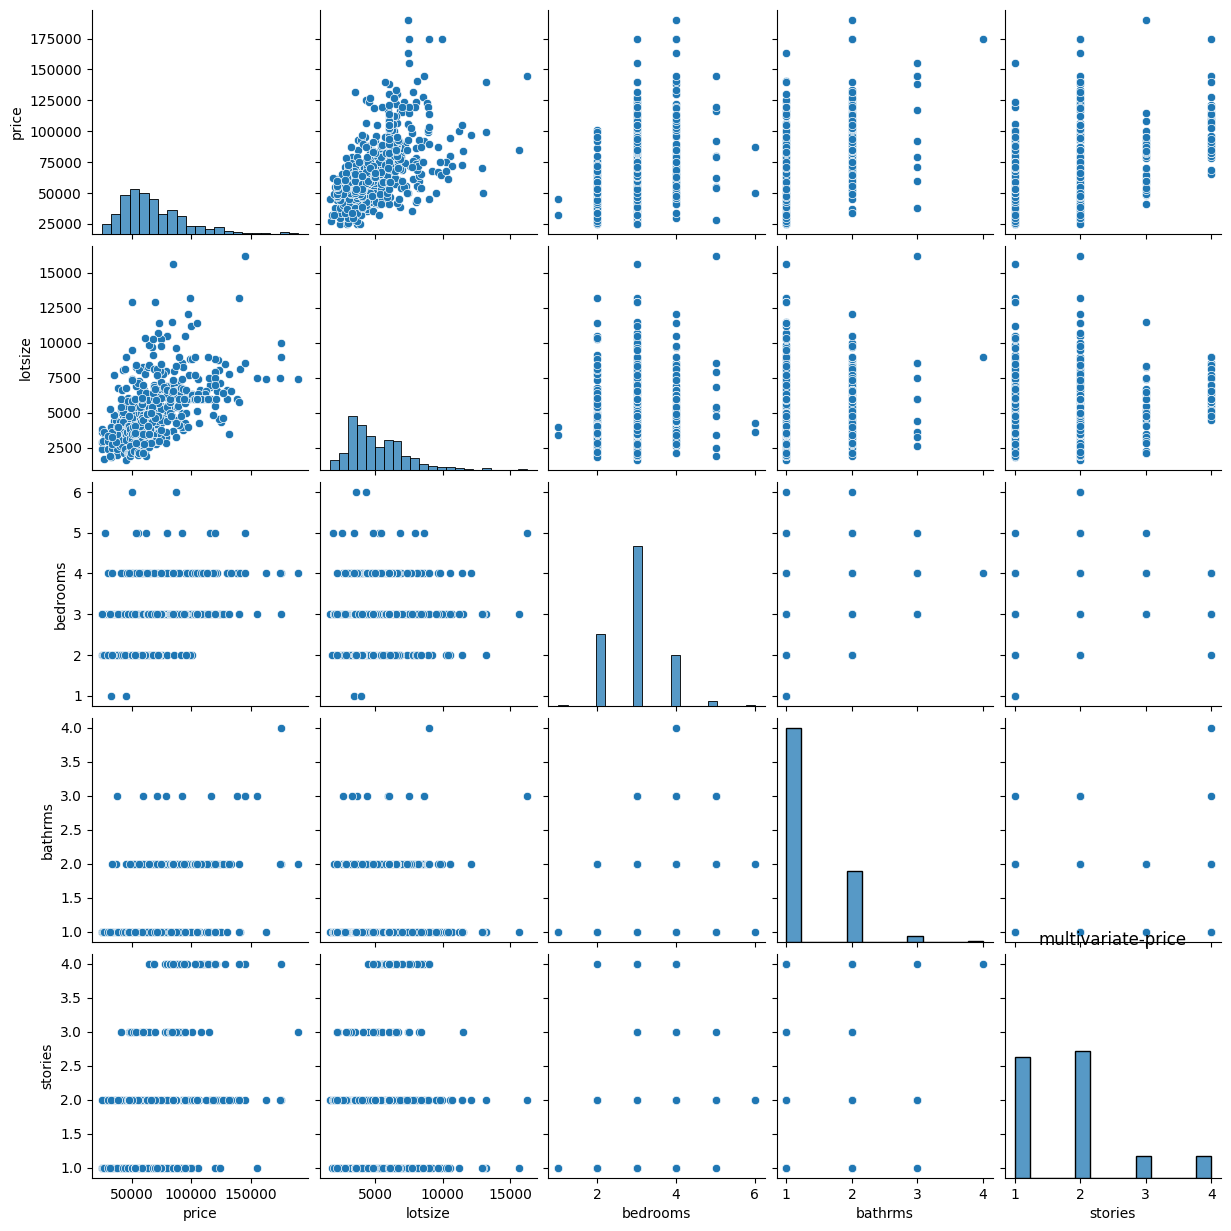

In [30]:
# draw pair plot
sns.pairplot(df_pd[['price', 'lotsize', 'bedrooms', 'bathrms', 'stories']])
plt.title("multivariate-price")
plt.show()

In [31]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# now use all numeric value
training2 = VectorAssembler(inputCols=["lotsize","bedrooms","bathrms","stories"], outputCol="features").transform(df)
training2.show(5)

+---+-------+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+--------------------+
|_c0|  price|lotsize|bedrooms|bathrms|stories|driveway|recroom|fullbase|gashw|airco|garagepl|prefarea|            features|
+---+-------+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+--------------------+
|  1|42000.0|   5850|       3|      1|      2|     yes|     no|     yes|   no|   no|       1|      no|[5850.0,3.0,1.0,2.0]|
|  2|38500.0|   4000|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|[4000.0,2.0,1.0,1.0]|
|  3|49500.0|   3060|       3|      1|      1|     yes|     no|      no|   no|   no|       0|      no|[3060.0,3.0,1.0,1.0]|
|  4|60500.0|   6650|       3|      1|      2|     yes|    yes|      no|   no|   no|       0|      no|[6650.0,3.0,1.0,2.0]|
|  5|61000.0|   6360|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|[6360.0,2.0,1.0,1.0]|
+---+---

In [32]:
# Just fit the model because we already defined "lr" before.
lrModel2 = lr.fit(training2)

# now we have 2 models:
# lrModel: univariate linear model: "lotsize" # lrModel2: multivariate linear model:
# "lotsize","bedrooms","bathrms","stories"

trainingSummary2 = lrModel2.summary

print("coefficients: %s" % str(lrModel2.coefficients))
print("intercept: %s" % str(lrModel2.intercept))

print("RMSE: %f" % trainingSummary2.rootMeanSquaredError)
print("r2: %f" % trainingSummary2.r2)
print("Adj r2: %f" % trainingSummary2.r2adj)

coefficients: [5.4290810180324485,2824.7176423076526,17104.939222461388,7634.781385203659]
intercept: -4008.8691494744385
RMSE: 18181.402779
r2: 0.535547
Adj r2: 0.532113


In [33]:
modelSummary(lrModel2)

Note: the last rows are the information for Intercept
## -------------------------------------------------
##   Estimate   |   Std.Error | t Values  |  P-value
##   5.429081   0.369246   14.703   0.000000
## 2824.717642 1214.790132    2.325   0.020426
## 17104.939222 1734.411323    9.862   0.000000
## 7634.781385 1007.960879    7.574   0.000000
## -4008.869149 3603.085721   -1.113   0.266365
## ---
## Mean squared error:  330563407.022113 , RMSE:  18181.402779
## Multiple R-squared: 0.535547 ,             Total iterations: 0


In [34]:
# 주차장 수를 넣으면
training3 = VectorAssembler(inputCols=["lotsize","bedrooms","bathrms","stories","garagepl"],\
                            outputCol="features").transform(df)
lrModel3 = lr.fit(training3)
trainingSummary = lrModel3.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
modelSummary(lrModel3)

RMSE: 17669.532000
r2: 0.561331
Note: the last rows are the information for Intercept
## -------------------------------------------------
##   Estimate   |   Std.Error | t Values  |  P-value
##   4.733357   0.379818   12.462   0.000000
## 2388.597873 1184.214940    2.017   0.044187
## 16147.838833 1695.672990    9.523   0.000000
## 7879.313772 981.450046    8.028   0.000000
## 5371.937318 953.508693    5.634   0.000000
## -2063.039255 3521.863169   -0.586   0.558268
## ---
## Mean squared error:  312212361.108616 , RMSE:  17669.532000
## Multiple R-squared: 0.561331 ,             Total iterations: 0


In [35]:
from pyspark.ml.feature import StringIndexer

dff = spark.createDataFrame([(0,"a"),(1,"b"),(2,"c"),(3,"a"),(4,"a"),(5,"c")],["id","category"])
indexer = StringIndexer(inputCol = "category", outputCol = "categoryIndex")
indexed = indexer.fit(dff).transform(dff)
indexed.show()

+---+--------+-------------+
| id|category|categoryIndex|
+---+--------+-------------+
|  0|       a|          0.0|
|  1|       b|          2.0|
|  2|       c|          1.0|
|  3|       a|          0.0|
|  4|       a|          0.0|
|  5|       c|          1.0|
+---+--------+-------------+



In [36]:
inputs = ["driveway","recroom","fullbase","gashw","airco","prefarea"]
outputs = ["drivewayIndex","recroomIndex","fullbaseIndex","gashwIndex","aircoIndex","prefareaIndex"]
indexer = StringIndexer(inputCols = inputs, outputCols = outputs)
indexed = indexer.fit(df).transform(df)
indexed.show()

+---+-------+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+-------------+------------+-------------+----------+----------+-------------+
|_c0|  price|lotsize|bedrooms|bathrms|stories|driveway|recroom|fullbase|gashw|airco|garagepl|prefarea|drivewayIndex|recroomIndex|fullbaseIndex|gashwIndex|aircoIndex|prefareaIndex|
+---+-------+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+-------------+------------+-------------+----------+----------+-------------+
|  1|42000.0|   5850|       3|      1|      2|     yes|     no|     yes|   no|   no|       1|      no|          0.0|         0.0|          1.0|       0.0|       0.0|          0.0|
|  2|38500.0|   4000|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|          0.0|         0.0|          0.0|       0.0|       0.0|          0.0|
|  3|49500.0|   3060|       3|      1|      1|     yes|     no|      no|   no|   no|       0|      n

In [37]:
training4 = VectorAssembler(inputCols=["lotsize","bedrooms","bathrms","stories","garagepl", "drivewayIndex","recroomIndex"],\
                            outputCol="features").transform(indexed)
lrModel4 = lr.fit(training4)
trainingSummary = lrModel4.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
modelSummary(lrModel4)

RMSE: 17026.463943
r2: 0.592680
Note: the last rows are the information for Intercept
## -------------------------------------------------
##   Estimate   |   Std.Error | t Values  |  P-value
##   4.163460   0.379963   10.958   0.000000
## 2707.575636 1150.913250    2.353   0.019005
## 15645.372976 1644.957213    9.511   0.000000
## 7392.312062 958.058139    7.716   0.000000
## 5038.260346 928.624512    5.426   0.000000
## -8654.906252 2251.676623   -3.844   0.000136
## 9591.916770 1955.414900    4.905   0.000001
## 1200.140804 3468.387317    0.346   0.729461
## ---
## Mean squared error:  289900474.405660 , RMSE:  17026.463943
## Multiple R-squared: 0.592680 ,             Total iterations: 0
